In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

# Sources and Credits

Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr


Data Set Information:

Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.
The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.


Attribute Information:

Date : year-month-day
Rented Bike count - Count of bikes rented at each hour
Hour - Hour of he day
Temperature-Temperature in Celsius
Humidity - %
Windspeed - m/s
Visibility - 10m
Dew point temperature - Celsius
Solar radiation - MJ/m2
Rainfall - mm
Snowfall - cm
Seasons - Winter, Spring, Summer, Autumn
Holiday - Holiday/No holiday
Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]

In [ ]:
# Reading the data frame
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)
# showing the top 5 values
# df.head()

In [ ]:
# setting the dataframe columns to our relevant data
df.columns = dataset_cols
# convert functional column as type integer
df["functional"] = (df["functional"] == "Yes").astype(int)
df.head()

In [ ]:
# Now, we'll use only for time where hour is equal to 12
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis = 1)
df.head()

In [ ]:
df = df.drop(["wind", "visibility", "functional"], axis=1)

In [ ]:
# Now, we are going to print and plot all the data
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.ylabel("Bike count at noon")
    plt.xlabel(label)
    plt.show()

# Training Validation and Test Dataset

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [ ]:
# Writing a function to get xy
def get_xy(dataframe, y_label, x_labels=None):
    # creating a deep copy of the data frame
    # Basically copying everything over
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        # if x_label is not defined then the values from the df are taken as x_labels
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            X = dataframe[x_labels].values
    y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X,y))
    
    return data, X, y

In [ ]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [ ]:
# Making an actual regression model
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

In [159]:
# This below code just prints the coefficient and the intercept for the given data model
print(temp_reg.coef_, temp_reg.intercept_)
# now we check assiciation using the R^2 value using the .score method
temp_reg.score(X_train_temp, y_train_temp)
# Here we get the value nearly, 0.34 which is more than zero (which means that there is no assication (At ZERO))
# This value also means that it is also not very good enough

# In short, the higher the number is the higher the number will be co-related

[[21.25220379]] [372.67087536]


0.33129306891596333

In [ ]:
# Plotting the line of best fit
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20,40,100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression

In [ ]:
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [ ]:
# setting up the Regression Model, and fitting the data into the model
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

In [158]:
# Getting the reg coefficient and score
print(all_reg.coef_, all_reg.intercept_)
all_reg.score(X_train_all, y_train_all)

[[ 15.88490381  -2.5447291    0.89516328 124.8962276  -75.77839666
  -58.11182139]] [356.25045999]


0.5077476916248685

# Regression with Neural Networks (Linear)

In [ ]:
# When using Neural Networks, it is benifitial to use normalizer we can use TF for this case
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [ ]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])
# Now, Since we are not passing any activation function, our output fot this 1D input will also be Linear

In [ ]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp,y_val_temp)
)

In [ ]:
# summarize history for loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_loss(history)

In [ ]:
# Plotting the Best Fit Line With the Neural Network Model (Linear)
# Plotting the line of best fit
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20,40,100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Neural Network (Complete)

In [ ]:
# Setting up the neural network model, with activation set to relu
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
# Here we can add any number of nodes and stuff in order to get the best fitting result

In [ ]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data = (X_val_temp, y_val_temp),
    verbose=0,
    epochs=100
)
plot_loss(history)

In [ ]:
 # Plotting the Best Fit Line With the Neural Network Model (Complete)
# Plotting the line of best fit
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20,40,100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Predicting Now With All the Data (Multi Regression)

In [ ]:
# When using Neural Networks, it is benifitial to use normalizer we can use TF for this case
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

In [ ]:
# Setting up the neural network model, with activation set to relu
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
# Here we can add any number of nodes and stuff in order to get the best fitting result

In [ ]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data = (X_val_all, y_val_all),
    verbose=0,
    epochs=100
)
plot_loss(history)

In [ ]:
# Calculate the MSE for both linear regressor and neural network
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

In [ ]:
# Method to calculate the MSE
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [ ]:
# Making the actual predictions
print(MSE(y_pred_lr, y_test_all), MSE(y_pred_nn, y_test_all))

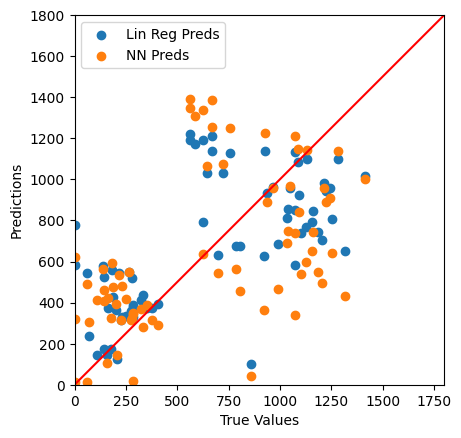

In [157]:
# Plotting real vs predicted MSE
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")